In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

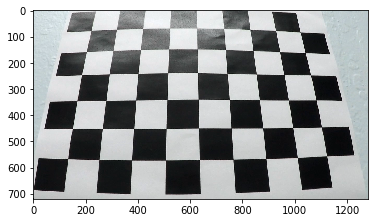

In [2]:
img_cal = cv2.imread('camera_cal/calibration3.jpg')
plt.imshow(img_cal)

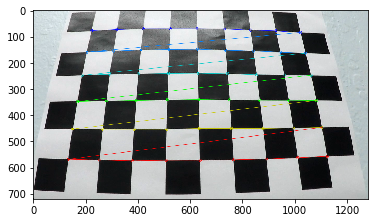

In [3]:
# prepare object points
nx = 9
ny = 6

# Convert to grayscale
gray = cv2.cvtColor(img_cal, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
# print(corners)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img_cal, (nx, ny), corners, ret)
    plt.imshow(img_cal)

In [4]:
corner1 = corners[0][0]
corner2 = corners[nx-1][0]
corner3 = corners[nx*(ny-1)][0]
corner4 = corners[(nx*ny)-1][0]
src = np.float32([corner1,corner2,corner3,corner4])
src

array([[ 224.43092,   78.4362 ],
       [1022.02966,   84.68181],
       [ 134.44388,  567.631  ],
       [1123.5201 ,  557.47186]], dtype=float32)

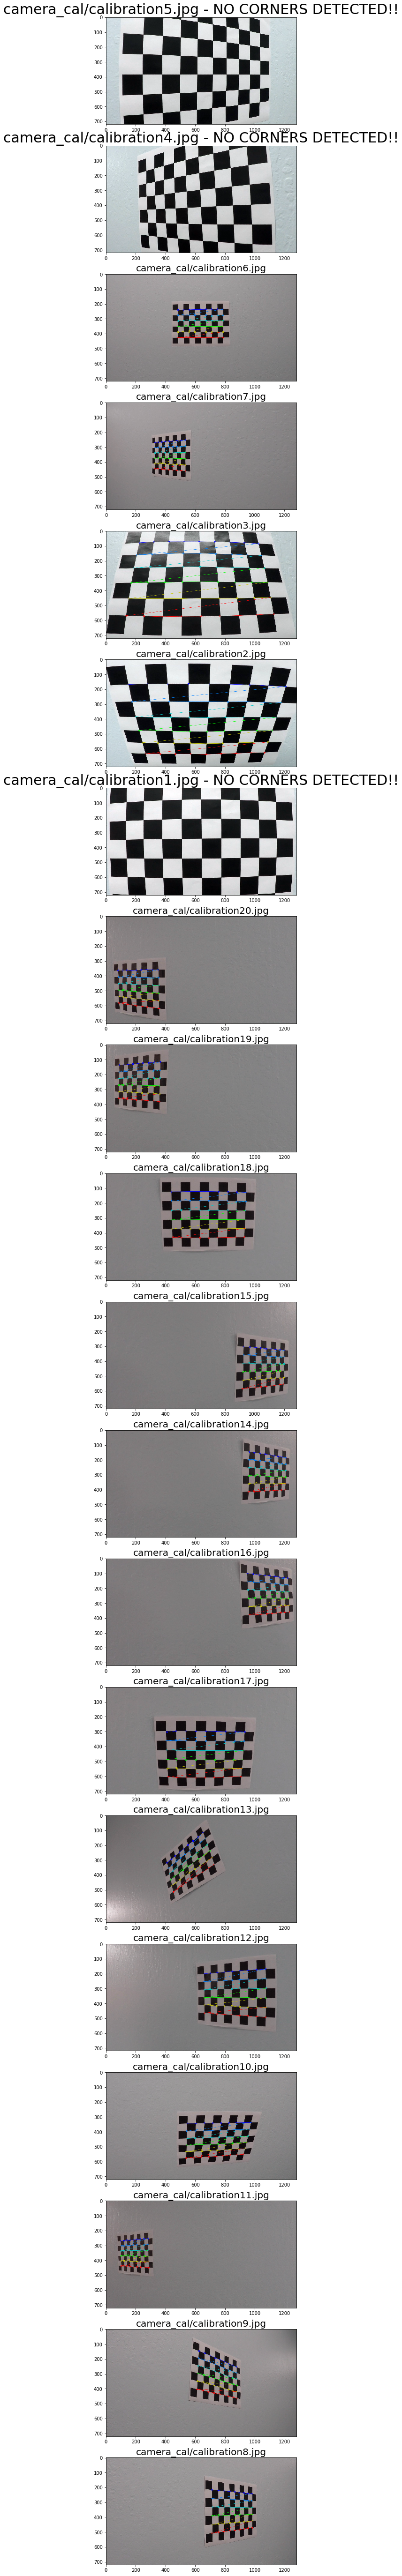

In [5]:
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')
n_it = len(images)

plt.figure(figsize=(10, 5*n_it))

for i in range(n_it):
    img = cv2.imread(images[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    ax = plt.subplot(n_it,1 ,i+1)
    if ret == True:
        # append objp and corners
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # draw corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        ax.imshow(img)
        plt.title(images[i], fontsize=20)
    else:
        ax.imshow(img)
        plt.title(images[i] + " - NO CORNERS DETECTED!!", fontsize=30)

In [6]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # undist = np.copy(img)  # Delete this line
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    print(img.shape[0:2])
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst, mtx, dist

In [7]:
# Test Image
img_test = cv2.imread('camera_cal/calibration3.jpg')

(720, 1280)


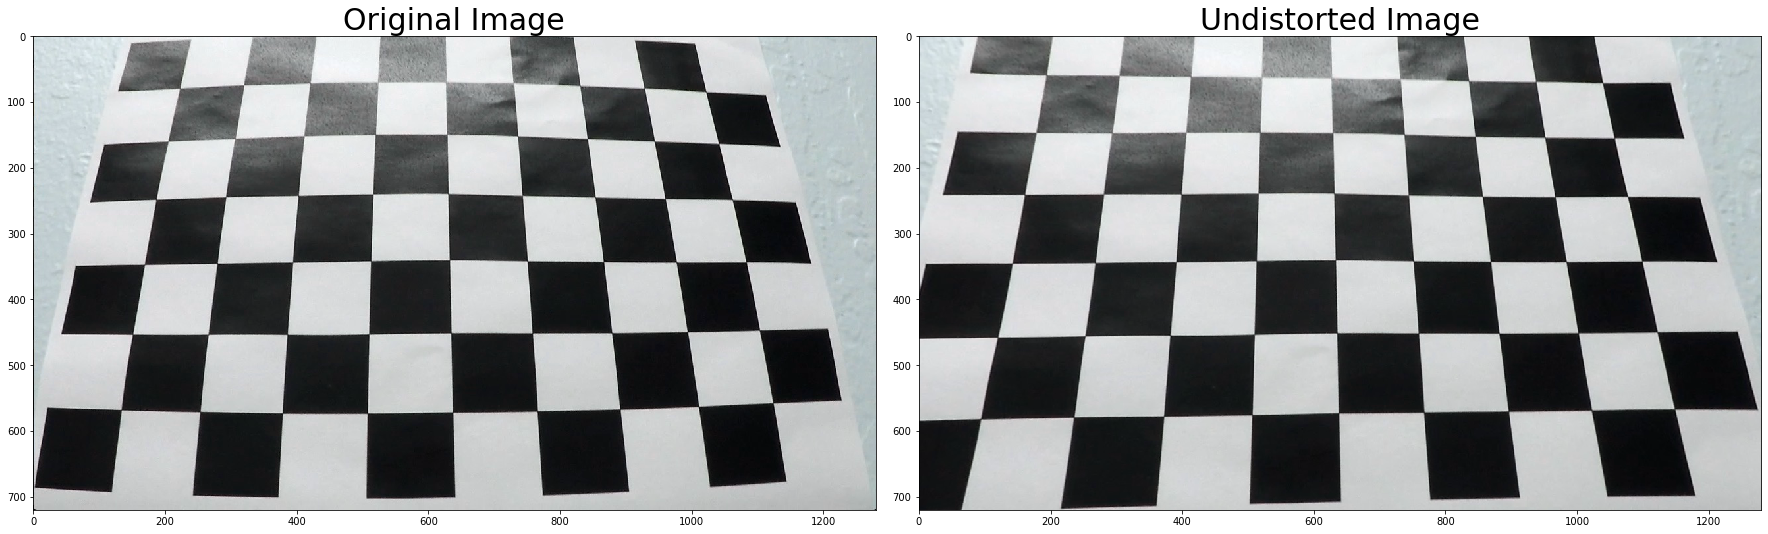

In [8]:
undistorted, mtx, dist = cal_undistort(img_test, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Save undisorted image
plt.imsave('results/01_undisorted.jpg', cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))

In [9]:
def corners_unwarp(img, nx, ny, mtx, dist, draw_corners = True):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        if draw_corners:
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        offset = 50 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])
        
        src_points = np.float32([corners[0],
                                 corners[nx-1], 
                                 corners[-1], 
                                 corners[-nx]])
        
        dst_points = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

<Figure size 432x288 with 0 Axes>

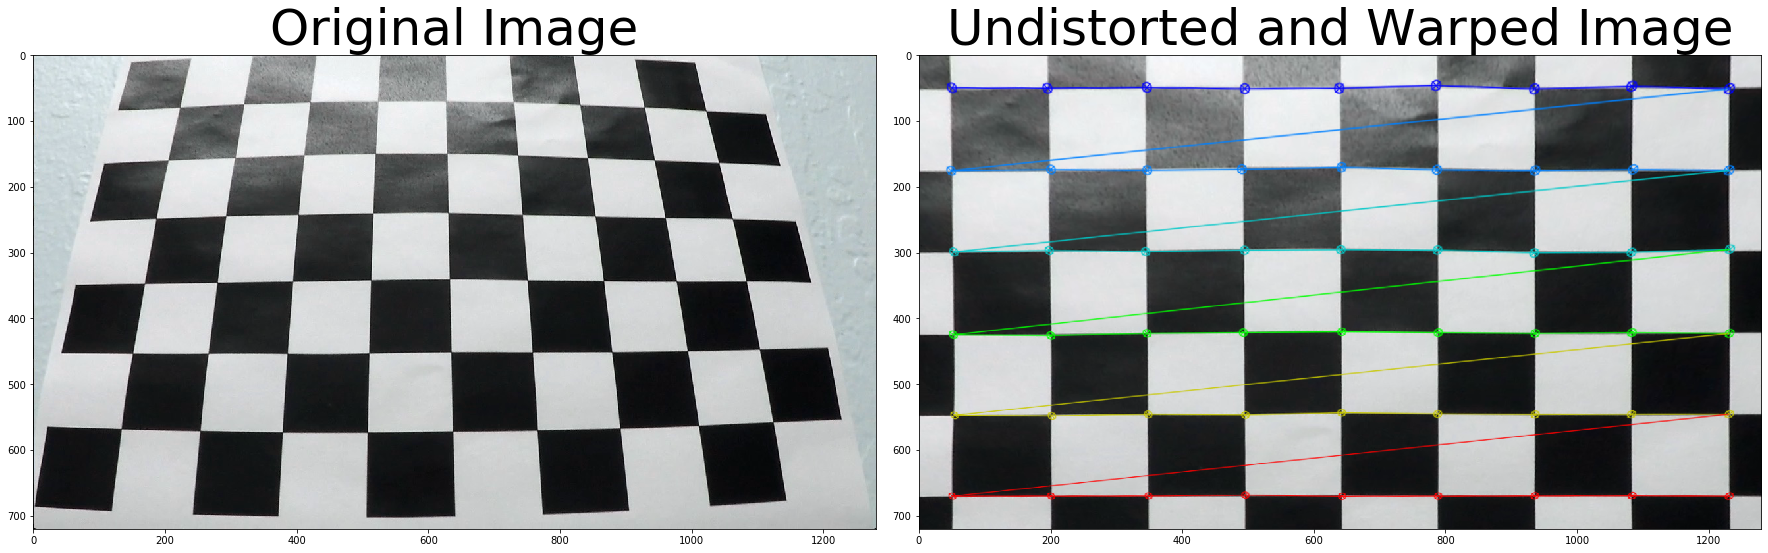

In [10]:
# Test Image
img_test = cv2.imread('camera_cal/calibration3.jpg')

top_down, perspective_M = corners_unwarp(img_test, nx, ny, mtx, dist, True)
plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
def corners_unwarp(img, nx, ny, mtx, dist, draw_corners = True):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        if draw_corners:
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        offset = 50 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])
        
        src_points = np.float32([corners[0],
                                 corners[nx-1], 
                                 corners[-1], 
                                 corners[-nx]])
        
        dst_points = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

<Figure size 432x288 with 0 Axes>

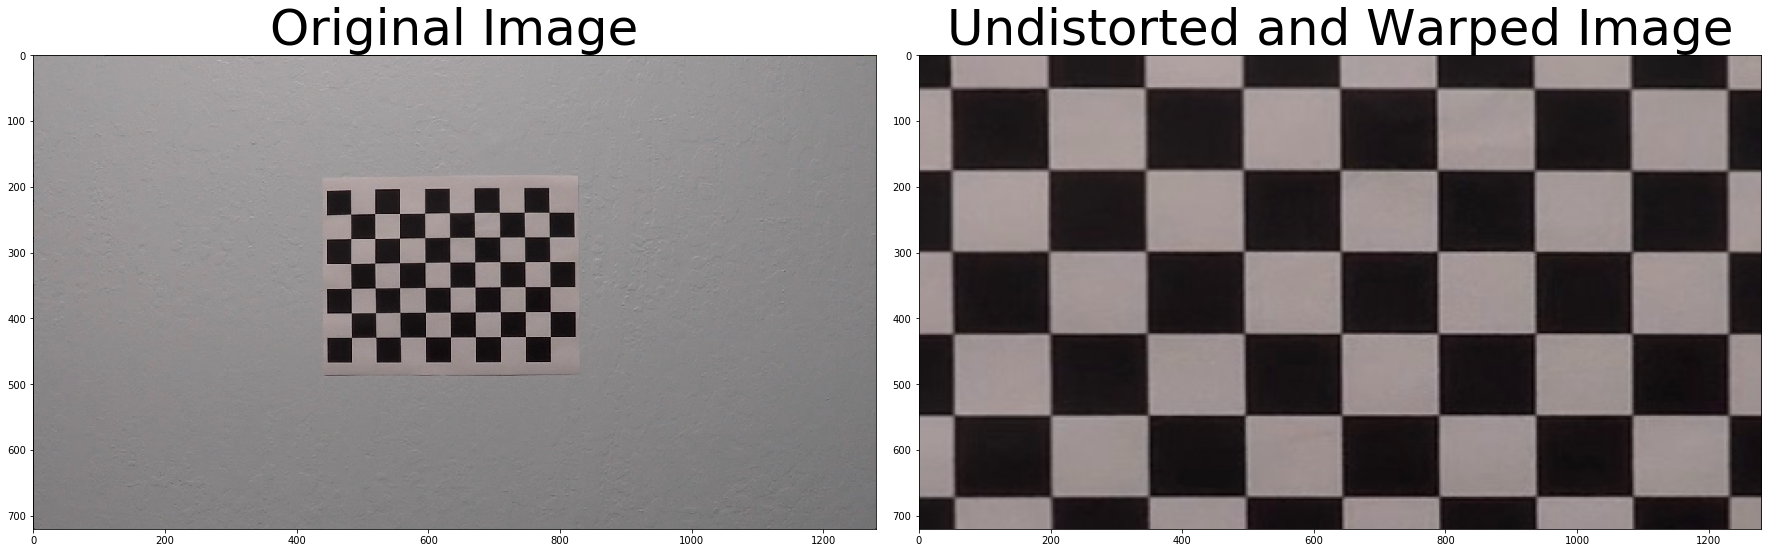

In [12]:
# Test Image
img_test = cv2.imread('camera_cal/calibration6.jpg')

im_unwrap, perspective_M = corners_unwarp(img_test, nx, ny, mtx, dist, False)
plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(im_unwrap)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

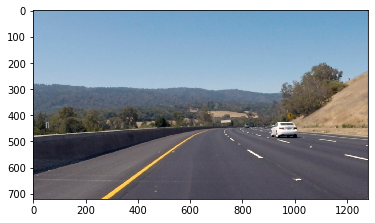

In [38]:
img_lane = cv2.imread('curved-lane.jpg')
plt.imshow(cv2.cvtColor(img_lane, cv2.COLOR_BGR2RGB))

In [79]:
lane_base_file_name = 'results/03_lane_lines_'
img_lane.shape

(720, 1280, 3)

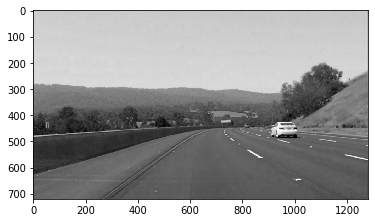

In [80]:
# BGR : blue color
plt.imshow(img_lane[:,:,0], cmap='gray')
plt.imsave(lane_base_file_name + 'blue.jpg',img_lane[:,:,0], cmap='gray')

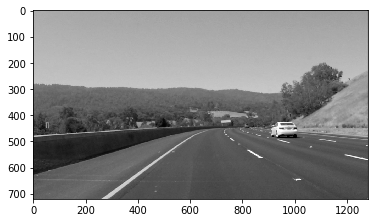

In [81]:
# BGR : green color
plt.imshow(img_lane[:,:,1], cmap='gray')
plt.imsave(lane_base_file_name + 'green.jpg',img_lane[:,:,1], cmap='gray')

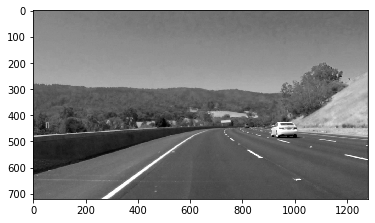

In [91]:
# BGR : red color
plt.imshow(img_lane[:,:,2], cmap='gray')
plt.imsave(lane_base_file_name + 'red.jpg',img_lane[:,:,2], cmap='gray')

In [83]:
hls_img_lane = cv2.cvtColor(img_lane, cv2.COLOR_BGR2HLS)
hls_img_lane.shape

(720, 1280, 3)

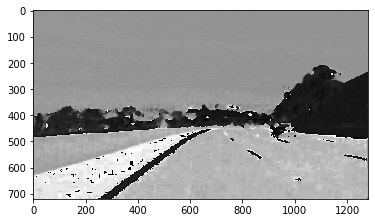

In [84]:
# HLS : H channel
plt.imshow(hls_img_lane[:,:,0], cmap='gray')
plt.imsave(lane_base_file_name + 'h_hls.jpg',hls_img_lane[:,:,0], cmap='gray')

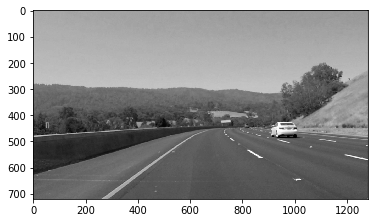

In [85]:
# HLS : L channel
plt.imshow(hls_img_lane[:,:,1], cmap='gray')
plt.imsave(lane_base_file_name + 'l_hls.jpg',hls_img_lane[:,:,1], cmap='gray')

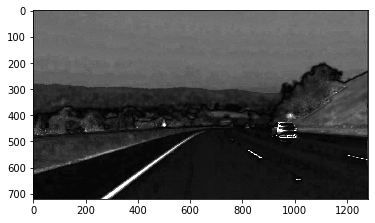

In [86]:
# HLS : S channel
plt.imshow(hls_img_lane[:,:,2], cmap='gray')
plt.imsave(lane_base_file_name + 's_hls.jpg',hls_img_lane[:,:,2], cmap='gray')

In [87]:
hsv_img_lane = cv2.cvtColor(img_lane, cv2.COLOR_BGR2HSV)
hsv_img_lane.shape

(720, 1280, 3)

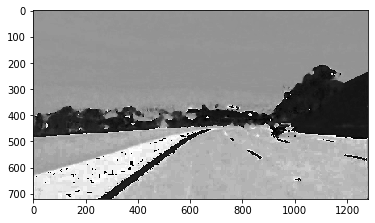

In [88]:
# HSV : H channel
plt.imshow(hsv_img_lane[:,:,0], cmap='gray')
plt.imsave(lane_base_file_name + 'h_hsv.jpg',hsv_img_lane[:,:,0], cmap='gray')

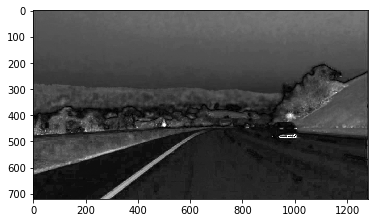

In [89]:
# HSV : S channel
plt.imshow(hsv_img_lane[:,:,1], cmap='gray')
plt.imsave(lane_base_file_name + 's_hsv.jpg',hsv_img_lane[:,:,1], cmap='gray')

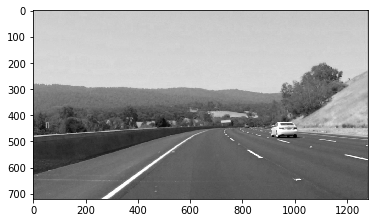

In [92]:
# HSV : V channel
plt.imshow(hsv_img_lane[:,:,2], cmap='gray')
plt.imsave(lane_base_file_name + 'v_hsv.jpg',hsv_img_lane[:,:,2], cmap='gray')

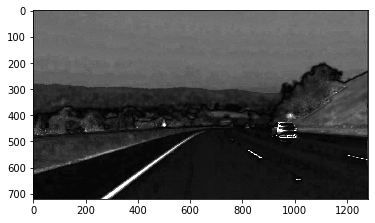

In [94]:
selected_channel = hls_img_lane[:,:,2]
plt.imshow(selected_channel, cmap='gray')

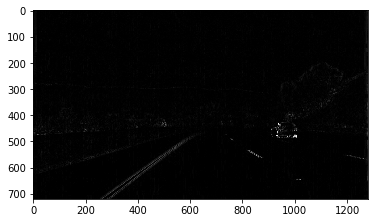

In [103]:
# plt.imshow(img_lane, cmap='bgr)
# gray = cv2.cvtColor(img_lane, cv2.COLOR_RGB2GRAY)
gray = selected_channel
sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobel = np.absolute(sobel)
scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
plt.imshow(scaled_sobel, cmap='gray')

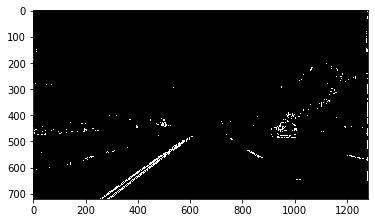

In [126]:
thresh_min = 20
thresh_max = 150
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')

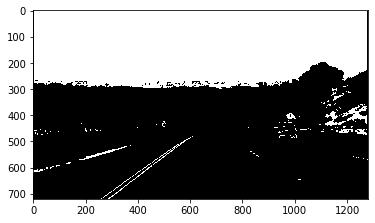

In [139]:
thresh = (90, 200)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
plt.imshow(binary, cmap='gray')

In [15]:
sxbinary.shape

(720, 1280)

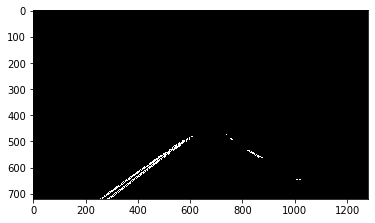

In [113]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


(height, width) = sxbinary.shape
## Region of interest
offset = 100
left_bottom = [offset, height]
right_bottom = [width, height]
apex = [((width+100)//2)-offset, 460]
apex2 = [((width+100)//2)+offset, 460]
corners = [left_bottom, right_bottom, apex2, apex]
area = np.array( [corners], dtype=np.int32 )
img_region = region_of_interest(sxbinary, area)
plt.imshow(img_region, cmap='gray')

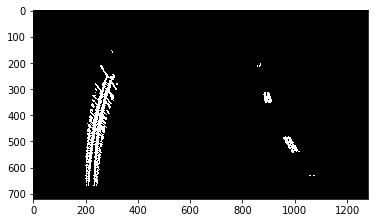

In [114]:
def bird_view(img, corners):
    offset = 50 # offset for dst points
    img_size = (img.shape[1], img.shape[0])

    src_points = np.float32(corners)

    dst_points = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])

    M = cv2.getPerspectiveTransform(src_points, dst_points)
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, M_inv

bird_view, M, M_inv = bird_view(img_region, corners[::-1])
plt.imshow(bird_view, cmap='gray')

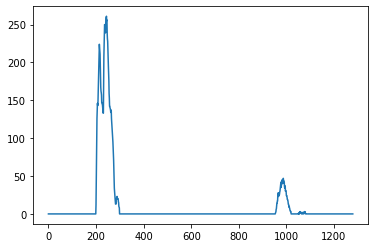

In [115]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(bird_view)

# Visualize the resulting histogram
plt.plot(histogram)

In [19]:
a = [1,2,3,4,5,6,7,8,9]

In [20]:
a[len(a)//2:]

[5, 6, 7, 8, 9]

In [21]:
thresh=(0, np.pi/2)

In [22]:
thresh[0]

0

In [23]:
## Bird Eye View

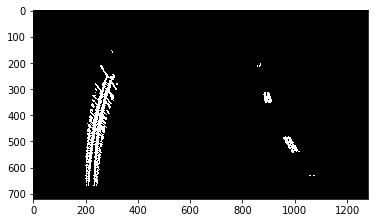

In [120]:
# img_bin = mpimg.imread('warped-example.jpg')/255
img_bin = bird_view
plt.imshow(img_bin, cmap='gray')

In [121]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

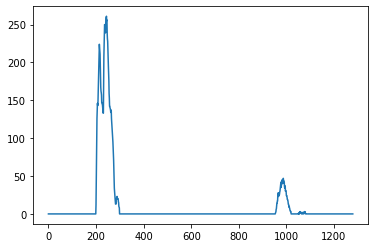

In [122]:
# Create histogram of image binary activations
histogram = hist(img_bin)

# Visualize the resulting histogram
plt.plot(histogram)

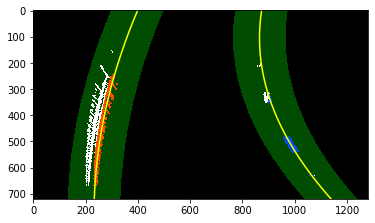

In [123]:
# Load our image - this should be a new frame since last time!
# binary_warped = mpimg.imread('warped-example.jpg')
binary_warped = bird_view

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

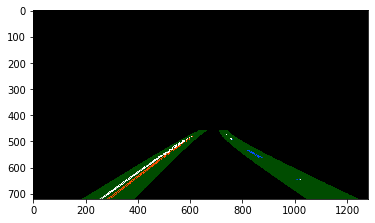

In [124]:
img_inv = cv2.warpPerspective(result, M_inv, (width, height)) # Inverse transformation
plt.imshow(img_inv, cmap='gray')

In [125]:
def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.060183165725 1976.296730771462
